# IMDB Sentiment Analysis with BiLSTM

This project builds a Bidirectional LSTM model to classify IMDB movie reviews as positive or negative. 
It includes data preprocessing, sequence padding, model training with early stopping, and evaluation. 
Sample predictions demonstrate the model's ability to analyze sentiment in text.


In [1]:
import warnings, numpy as np, tensorflow as tf
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Define parameters
max_features = 20_000   # maximum number of words in vocabulary
max_len      = 200      # maximum length of a sequence

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to the same length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test  = pad_sequences(x_test,  maxlen=max_len)

print(f"Train: {x_train.shape}  Test: {x_test.shape}")

Train: (25000, 200)  Test: (25000, 200)


In [14]:
# Model hyperparameters
embedding_dim = 128
lstm_units    = 64

# Build the model
model = Sequential([
    Embedding(
        input_dim=max_features,
        output_dim=embedding_dim,
        input_length=max_len
    ),

# Bidirectional LSTM layer
    Bidirectional(
        LSTM(lstm_units, return_sequences=False)
    ),

    Dropout(0.3),                 #reduce overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')    #binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_lstm.keras', save_best_only=True, monitor='val_accuracy')
]
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/20
157/157 - 150s - 957ms/step - accuracy: 0.7552 - loss: 0.4766 - val_accuracy: 0.8678 - val_loss: 0.3213
Epoch 2/20
157/157 - 136s - 868ms/step - accuracy: 0.9105 - loss: 0.2328 - val_accuracy: 0.8576 - val_loss: 0.3265
Epoch 3/20
157/157 - 146s - 931ms/step - accuracy: 0.9366 - loss: 0.1792 - val_accuracy: 0.8506 - val_loss: 0.3791
Epoch 4/20
157/157 - 130s - 828ms/step - accuracy: 0.9460 - loss: 0.1491 - val_accuracy: 0.8670 - val_loss: 0.3625


In [ ]:
# Evaluate the model on test data
score, acc = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
print(f"\nTest loss : {score:.4f}")
print(f"Test acc  : {acc:.4f}")


Test loss : 0.3296
Test acc  : 0.8624


In [ ]:
# Get word index mapping
word_index = imdb.get_word_index()
index_offset = 3

# Function to encode text reviews to sequences
def encode_review(text):
    tokens = text_to_word_sequence(text.lower())
    seq = [
        word_index.get(t, 2) + index_offset
        for t in tokens
        if (word_index.get(t, 2) + index_offset) < max_features
    ]
    return seq

In [ ]:
# Function to predict sentiment of reviews
def predict_reviews(reviews, threshold=0.5):
    seqs = [encode_review(r) for r in reviews]

    padded = pad_sequences(seqs, maxlen=max_len)

    probs  = model.predict(padded).ravel()

    labels = (probs >= threshold).astype(int)
    
    for r, p, l in zip(reviews, probs, labels):
        print(f"{p:0.3f}  ({'pos' if l else 'neg'})  -> {r}")

In [ ]:
# Sample reviews to test the model
sample_reviews = [
    "This movie was wonderful and inspiring",
    "Terrible plot and awful acting",
    "Not bad but could be better",
    "Absolutely fantastic! I loved every minute",
    "The film was boring and too slow"
]

predict_reviews(sample_reviews)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0.878  (pos)  -> This movie was wonderful and inspiring
0.093  (neg)  -> Terrible plot and awful acting
0.252  (neg)  -> Not bad but could be better
0.848  (pos)  -> Absolutely fantastic! I loved every minute
0.303  (neg)  -> The film was boring and too slow


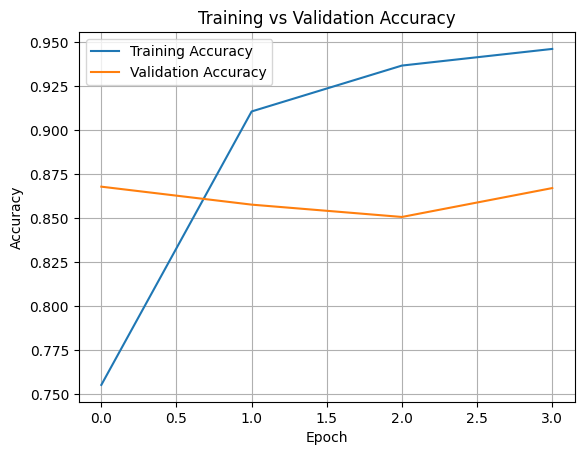

In [13]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid()
plt.show()
